## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 探索数据集](#eda)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)
- [IV - 影响转化的其他因素](#otherfactors)
- [V - 结论](#conclusion)
- [参考资料](#reference)

<a id='intro'></a>
### 简介

本项目设定了一个电子商务网站运营的A/B测试情景，该公司设计了新网站页面，想提高用户转化率，即购买公司产品的用户数量。

该项目重点解决以下问题：

1. 该公司应该使用新页面还是保留旧页面？
2. 通过拟合回归模型，用户收到不同页面是否存在显著的转化差异？
3. 是否有影响用户发生转化的其他因素？


<a id='eda'></a>
### I - 探索数据集


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
#导入数据集，查看前几行
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#查看数据集中的行数
df.shape[0]

294478

In [4]:
#查看数据集中独立用户的数量
df['user_id'].nunique()

290584

In [5]:
#查看用户转化的比例
df['converted'].mean()

0.11965919355605512

In [6]:
#查看new_page 与 treatment 不一致的次数，即new_page - control 或 old_page - treatment
df.groupby('landing_page')['group'].value_counts()

landing_page  group    
new_page      treatment    145311
              control        1928
old_page      control      145274
              treatment      1965
Name: group, dtype: int64

In [7]:
#查看是否有任何行存在缺失值
df.isnull().any().sum()

0

由于存在 **treatment** 与 **new_page** 不一致，或 **control** 与 **old_page** 不一致的行，我们不能确定该行是否真正接收到了新的或旧的页面，在此应该删除这些混乱的数据。


In [8]:
#查询control - old_page, treatment - new_page不一致的行，分别存储为数据集
df_c_o = df.query('group == "control" and landing_page == "old_page"')
df_t_n = df.query('group == "treatment" and landing_page == "new_page"')

In [9]:
#检查新数据集行数
print(df_c_o.shape[0])
print(df_t_n.shape[0])

145274
145311


In [10]:
#合并数据集为df2
df2 = df_c_o.merge(df_t_n, how='outer')

In [11]:
#检查是否已正确处理混乱数据
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
#查看df2中的唯一 **user_id**
df2.user_id.nunique()

290584

In [13]:
#查看df2中是否有重复的 **user_id** 
df2.user_id.value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
801490    1
799443    1
787157    1
793302    1
817882    1
842446    1
815835    1
805596    1
803549    1
809694    1
807647    1
895712    1
840399    1
836301    1
899810    1
834242    1
936604    1
934557    1
940702    1
938655    1
830144    1
828097    1
832195    1
838348    1
821956    1
         ..
734668    1
736717    1
730574    1
775632    1
771538    1
642451    1
773587    1
783828    1
785877    1
779734    1
781783    1
759256    1
726472    1
748999    1
746950    1
753093    1
751044    1
740803    1
738754    1
744897    1
742848    1
634271    1
632222    1
636316    1
630169    1
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

In [14]:
#查看重复的行信息
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
146212,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
#删除一个重复id，储存至df2
df2 = df2.drop(index=146212)

In [16]:
#不管用户收到什么页面，单个用户的转化率
df2.converted.mean()

0.11959708724499628

In [17]:
#假定一个用户处于control组的转化率
control_ctr = df2.query('group == "control"')['converted'].mean()
control_ctr

0.1203863045004612

In [18]:
#假定一个用户处于treatment组中的转化率
treatment_ctr = df2.query('group == "treatment"')['converted'].mean()
treatment_ctr

0.11880806551510564

In [19]:
#一个用户收到新页面的概率
len(df2.query('landing_page == "new_page"'))/df2.shape[0]

0.5000619442226688

**结论：**
根据上述数据显示，用户处于control组和treatment组的转化率差异仅为0.15，没有足够证据表明哪个页面可以带来更多转化。


<a id='ab_test'></a>
### II - A/B 测试



假设旧页面转化率为**$p_{old}$** ，新页面转化率为**$p_{new}$** ，I类错误阈值(α)为5%。<br>
零假设：旧页面的效果与新页面相同甚至更好； <br>
备假设：新页面效果比旧页面更好。<br>

$$ H_0: P{new} - P{old} <= 0 $$
$$ H_1: P{new} - P{old} > 0 $$

假设 $P{old}$ 和 $P{new}$ 都等于**ab_data.csv** 中的转化率，新旧页面都是如此。 
每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。<br>
执行两次页面之间转化差异的抽样分布，计算零假设中10000次迭代计算的估计值。  

In [20]:
#零假设中，计算p_new的转化率 
p_new = df2['converted'].mean()
p_new

0.11959708724499628

In [21]:
#在零假设中， 计算p_old 的转化率
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [22]:
#计算n_new 和 n_old 。
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

In [23]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

假设转化成功，使用$P{new}$和np.random.choice来模拟转化成功的情况，0代表无，1代表有，同时将这个模拟存储在new_page_conveted中。

In [24]:
new_page_converted = np.random.choice([0,1], n_new, p=(1-p_new, p_new))

同上，使用$P{old}$和np.random.choice来模拟转化成功的情况。

In [25]:
old_page_converted = np.random.choice([0,1], n_old, p=(1-p_old, p_old))

找到 $p_{new}$ - $p_{old}$ 模拟值。

In [26]:
diff_mean = new_page_converted.mean() - old_page_converted.mean()

使用抽样分布，模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [27]:
p_diffs = []    
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p=(1-p_new, p_new))
    old_page_converted = np.random.choice([0,1], n_old, p=(1-p_old, p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


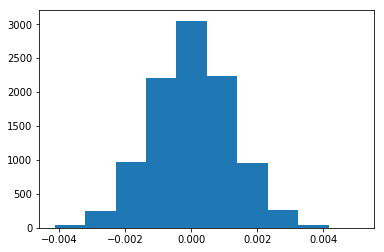

In [28]:
#绘制 p_diffs 直方图
plt.hist(p_diffs);

计算**p_diffs**的数据有多大比例大于**ab_data.csv**中实际观察到的差值。

In [29]:
#ab_data.csv中的实际差值
obs_diff = treatment_ctr - control_ctr

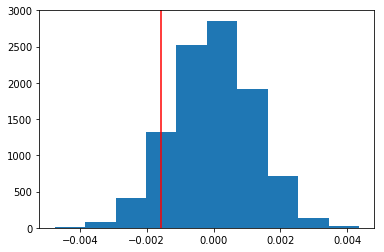

In [30]:
#模拟零假设
diffs = np.array(p_diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)
plt.hist(null_vals);
plt.axvline(obs_diff, c='r');

In [31]:
#计算p值
(null_vals > obs_diff).mean()

0.9009

**结论：** 在**p_diffs**列表的数值中，约90%大于 **ab_data.csv** 中观察到的实际差值。这个值是p值（p-value），用于衡量生成结果是否超出了随机变异的范围，也被称为统计显著性。由于I类错误阈值(α）为5%，即P > α，因此我们不能拒绝零假设。在这部分我们可以得出的结论为，旧页面效果与新页面相同，甚至更好。


<a id='regression'></a>
### III - 回归分析法
在之前的A / B测试中获得的结果，其实也可以通过执行回归来获取。由于每行的值是转化或不转化，在这种情况下我们应该执行逻辑回归。<br><br>


使用 **statsmodels** 来拟合指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。首先，为模型的截距创建一个column ，并为每个用户收到的页面创建一个虚拟变量列，即添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [32]:
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('control', axis=1)

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


使用 **statsmodels** 导入回归模型，使用刚才创建的2个列来拟合该模型。

In [34]:
import statsmodels.api as sm
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [35]:
#显示模型摘要
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        19:06:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [36]:
#对相关系数(coef)进行指数化
intercept = 1/np.exp(-1.9888)
ab_page = 1/np.exp(-0.0150)

print(intercept)
print(ab_page)

7.3067603868728614
1.015113064615719


**结论：**
从上述分析可发现，与ab_page关联的p值是0.190。该值与我们在第二部分发现的结果不同，是因为回归模型中的p值通常用于测试截距和斜率的参数是否等于0，或是否等于0假设，也就是说，在上述回归模型的摘要中，ab_page的零假设是ab_page的斜率$b_1$=0，备假设是$b_1$≠0。

<a id='otherfactors'></a>
### IV - 影响转化的其他因素

在回归模型中添加附加项有可能产生以下弊端，如果X变量之间相关性较强，变量之间有可能产生多重共线性，将会导致估计值对于模型的轻微变化异常敏感，从而导致系数估计值不稳定。

现在，我们导入**countries.csv** 数据集。根据用户居住的国家或地区添加一个 effect 项，查看国家项是否对转化产生影响。

In [37]:
#导入数据集
df3 = pd.read_csv('countries.csv')

In [38]:
#创建虚拟变量，同时合并数据集，删除虚拟变量US
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.merge(df2, on='user_id')
df3 = df3.drop('US', axis=1)

In [39]:
df3.head()

,user_id,country,CA,UK,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,0,1,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,0,0,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,0,1,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,0,1,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,0,1,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [40]:
#创建回归模型
logit_mod = sm.Logit(df3['converted'], df3[['intercept','CA','UK']])
results = logit_mod.fit()
#查看摘要
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 07 Aug 2019   Pseudo R-squ.:               1.521e-05
Time:                        19:06:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [41]:
#对相关系数(coef)进行指数化
df3_intercept = 1/np.exp(-1.9967)
df3_CA = 1/np.exp(-0.0408)
df3_US = np.exp(0.0099)

print(df3_intercept)
print(df3_CA)
print(df3_US)

7.364712402994374
1.0416437559600236
1.0099491671175422


**结论：** 从统计摘要的p值中看，CA值与UK值均大于0.05（alpha值），因此国家与转化率之间缺乏统计显著性，因此我们不能拒绝零假设。

现在已经查看了国家与页面在转化率在个体上的影响，接下来我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。

In [42]:
#上面已经创建了old_page, new_page的虚拟变量，直接用
df3['new_CA'] = df3['ab_page'] * df3['CA']
df3['new_UK'] = df3['ab_page'] * df3['UK']

In [43]:
#检查数据集
df3.head()

,user_id,country,CA,UK,timestamp,group,landing_page,converted,intercept,ab_page,new_CA,new_UK
0,834778,UK,0,1,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
1,928468,US,0,0,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
2,822059,UK,0,1,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
3,711597,UK,0,1,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
4,710616,UK,0,1,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [44]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page','CA','UK','new_CA','new_UK']])
results = logit_mod.fit()
#查看摘要
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 07 Aug 2019   Pseudo R-squ.:               3.482e-05
Time:                        19:06:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**结论：** 根据上述摘要，可以看出无论是否添加交叉项，由于p值>0.05，都没有足够证据表明我们可以拒绝零假设，也即是说，页面与国家/地区之间的相互作用并不能证明其会对转化产生重大影响。

<a id='conclusion'></a>
### 结论

在本项目中，我们尝试使用三种统计方法来对新旧页面的效果进行推理。<br>

首先，我们使用了假设检验和模拟零假设来检验以下假设，即 $H_0$：旧页面效果更好或者与新页面相当，$H_1$：新页面比旧页面更好，在I类错误阈值为5%的情况下，我们发现p值约为0.9，并没有足够证据表明我们可以拒绝零假设；<br>

其次，我们通过逻辑回归方法检测用户受到不同页面是否存在显著的转化差异，但结果仍未能拒绝零假设；<br>

最后，我们尝试添加交叉项，也即查看页面与国家/地区之间的相互作用能否对转化产生重大影响，结果仍然与上文保持一致。<br>

从上述推断，旧页面的效果与新页面相当，甚至比新页面更好，因此，不建议贵公司发布新页面。